In [5]:
import sys
import time

TOTAL_BAR_LENGTH = 80
LAST_T = time.time()
BEGIN_T = LAST_T


def progress_bar(current, total, msg=None):
    global LAST_T, BEGIN_T
    if current == 0:
        BEGIN_T = time.time()  # Reset for new bar.

    current_len = int(TOTAL_BAR_LENGTH * (current + 1) / total)
    rest_len = int(TOTAL_BAR_LENGTH - current_len) - 1

    sys.stdout.write(' %d/%d' % (current + 1, total))
    sys.stdout.write(' [')
    for i in range(current_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    current_time = time.time()
    step_time = current_time - LAST_T
    LAST_T = current_time
    total_time = current_time - BEGIN_T

    time_used = '  Step: %s' % format_time(step_time)
    time_used += ' | Tot: %s' % format_time(total_time)
    if msg:
        time_used += ' | ' + msg

    msg = time_used
    sys.stdout.write(msg)

    if current < total - 1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()


# return the formatted time
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    seconds_final = int(seconds)
    seconds = seconds - seconds_final
    millis = int(seconds*1000)

    output = ''
    time_index = 1
    if days > 0:
        output += str(days) + 'D'
        time_index += 1
    if hours > 0 and time_index <= 2:
        output += str(hours) + 'h'
        time_index += 1
    if minutes > 0 and time_index <= 2:
        output += str(minutes) + 'm'
        time_index += 1
    if seconds_final > 0 and time_index <= 2:
        output += str(seconds_final) + 's'
        time_index += 1
    if millis > 0 and time_index <= 2:
        output += str(millis) + 'ms'
        time_index += 1
    if output == '':
        output = '0ms'
    return output

In [6]:
from torch.utils import data as data
from torchvision import transforms
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize
import os
from astropy.io import fits
from skimage.transform import resize
import numpy as np

IMG_EXTENSIONS = [".fits"]

def input_transform():
    return Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1500,))
    ])

def target_transform():
    return Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1500,))
    ])

def is_image_file(filename):
    """
    Helper Function to determine whether a file is an image file or not
    :param filename: the filename containing a possible image
    :return: True if file is image file, False otherwise
    """
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


def make_dataset(dir):
    """
    Helper Function to make a dataset containing all images in a certain directory
    :param dir: the directory containing the dataset
    :return: images: list of image paths
    """
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname):
                path = os.path.join(root, fname)
                images.append(path)

    return images


def default_fits_loader(file_name: str, img_size: tuple):
    file = fits.open(file_name)
    if np.all(file[0].data) == None:
        _data = file[1].data
    else:
        _data = file[0].data
#    _data[_data != _data] = 0 
    _data = resize(_data, img_size)
    
    # _data = fits.get_data(file_name).resize(img_size)

    # add channels
    if len(_data.shape) < 3:
        _data = _data.reshape((*_data.shape,1))
    # TODO: Insert Custom Label Loader
    _target = _data
#    print(np.nanmax(_data))
    return _data, _target


class FITSDataset(data.Dataset):
    def __init__(self, data_path, input_transform, target_transform, img_size):
        self.data_path = data_path
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.img_size = img_size

        self.img_files = make_dataset(data_path)

    def __getitem__(self, index):
        _img, _target = default_fits_loader(self.img_files[index], self.img_size)
        _img = np.clip(_img,-1500,1500)
        _img = _img[1024:3072, 1024:3072]
#        print(np.nanmax(_img))
        _target = np.clip(_target,-1500,1500)
        _target = _target[1024:3072, 1024:3072]
#        print(np.nanmax(_target))
        _img = resize(_img, (1024, 1024),preserve_range=True,anti_aliasing=True)
#        print(np.nanmax(_img))
#        print(np.nanmin(_img))
        if self.input_transform:
            _img = self.input_transform(_img)
            _img[_img != _img] = -1
        if self.target_transform:
            _target = self.target_transform(_target)
            _target[_target != _target] = -1
        _data = (_img, _target)
        
        return _data

    def __len__(self):
        return len(self.img_files)

scale = 4
train_dataset = FITSDataset("/home/mhabeeb2/data/HMI.fits/train", input_transform(),target_transform(),(1024*scale,1024*scale))
test_dataset = FITSDataset("/home/mhabeeb2/data/HMI.fits/test", input_transform(),target_transform(),(1024*scale,1024*scale))
training_data_loader = data.DataLoader(train_dataset, num_workers=2, batch_size=4, shuffle=True)
testing_data_loader = data.DataLoader(test_dataset, num_workers=2, batch_size=4, shuffle=False)

In [7]:
for batch_num, (data, target) in enumerate(training_data_loader):
    print(data.shape)
    print(target.shape)
#     print(data)
#     print(np.nanmin(data))
#     print(np.nanmax(data))
    break
# for batch_num, (data, target) in enumerate(testing_data_loader):
#     print(data.shape)
#     print(target.shape)
#     print(np.nanmax(data))
#     break

torch.Size([4, 1, 1024, 1024])
torch.Size([4, 1, 2048, 2048])


In [51]:
from torch.utils.data import DataLoader
import torch
from astropy.io import fits
import numpy as np
import math
from math import log10
from SRCNN import Net
#from ResNet import Net

#SRCNN
#model = Net(2)

#Residual Net
#model = Net(num_channels=1, upscale_factor=2, base_channel=64, num_residuals=4)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#model.weight_init(mean=0.0, std=0.01)
criterion = torch.nn.MSELoss()

def train():
    model.train()
    train_loss = 0
    for batch_num, (data, target) in enumerate(training_data_loader):
        optimizer.zero_grad()
        loss = criterion(model(data.float()), target.float())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        progress_bar(batch_num, len(training_data_loader), 'Loss: %.4f' % (train_loss / (batch_num + 1)))

    print("    Average Loss: {:.4f}".format(train_loss / len(training_data_loader)))

def test():
    model.eval()
    avg_psnr = 0

    with torch.no_grad():
        for batch_num, (data, target) in enumerate(testing_data_loader):
            prediction = model(data.float())
            mse = criterion(prediction, target.float())
            psnr = 10 * log10(1 / mse.item())
            avg_psnr += psnr
            progress_bar(batch_num, len(testing_data_loader), 'PSNR: %.4f' % (avg_psnr / (batch_num + 1)))

    print("    Average PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))
for epoch in range(1, 2):
    train()
    test()

SyntaxError: can't assign to function call (<ipython-input-51-6b38d6716323>, line 10)

# Super Resolution

In [8]:
from torch.utils import data as data
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg", ".fits"])
    def __len__(self):
        return len(self.image_filenames)
class SuperResolve(data.Dataset):
    def __init__(self, data_path, input_transform):
        self.data_path = data_path
        self.input_transform = input_transform
        self.img_files = make_dataset(data_path)
        
    def __getitem__(self, index):
        _img, _target = default_fits_loader(self.img_files[index], (1024,1024))
#        _img = _img[1024:3072, 1024:3072]
        _img = np.clip(_img,-1500,1500)
        if self.input_transform:
            _img = self.input_transform(_img)
            _img[_img != _img] = -1
        return _img
    def __len__(self):
        return len(self.img_files)    

# BICUBIC INTERPOLATION

In [9]:
import torch.nn as nn
import torch.nn.functional as F
m = nn.Upsample(scale_factor=0.5, mode='bicubic')
validation_dataset = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/train"
validation_dataset = SuperResolve(validation_dataset, input_transform())
validation_data_loader = data.DataLoader(validation_dataset, batch_size=2)
for i, new in enumerate(validation_data_loader):
    print(new.shape)
    print(new.max())
    break
out_dd = m(new)
print(out_dd.shape)

torch.Size([2, 1, 1024, 1024])
tensor(0.6021, dtype=torch.float64)
torch.Size([2, 1, 512, 512])


/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


In [10]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)


smoothing = GaussianSmoothing(1, 3, 1)

In [11]:
import torch.nn.functional as F
i1 = smoothing(new.float())
out = F.interpolate(i1, size=512)
out.shape

torch.Size([2, 1, 512, 512])

In [12]:
import torch.nn as nn
import torch.nn.functional as F
m = nn.Upsample(scale_factor=2, mode='bilinear')
out_nn = m(out)
print(out_nn.shape)
out_nn.min()

torch.Size([2, 1, 1024, 1024])


/home/mhabeeb2/miniconda3/lib/python3.7/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(-1.)

In [13]:
from math import log10
criterion = torch.nn.MSELoss()
mse = criterion(out_nn, new)
psnr = 10 * log10(1 / mse.item())
psnr

26.981695812886315

# Super Resolving with initial Model

In [20]:
from __future__ import print_function
import argparse
import torch
from torchvision.transforms import ToTensor
from torch.utils import data as data
import numpy as np
# validation_dataset = FITSDataset("/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation", input_transform(),target_transform(),(1024,1024))
# validation_data_loader = data.DataLoader(validation_dataset, batch_size=1)

validation_dataset = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation"
#model = netG
validation_dataset = SuperResolve(validation_dataset, input_transform())
validation_data_loader = data.DataLoader(validation_dataset, batch_size=2)
for i, l1 in enumerate(validation_data_loader):
    print(l1.min())
    print(l1.max())
out = model(l1)

print(out.shape)
print(out.max())
denormalize = out*1500
print(denormalize.min())
print(denormalize.max())

tensor(-1.)
tensor(0.5425)


NameError: name 'model' is not defined

# Visualizations

In [17]:
import matplotlib.pyplot as plt
file_name = "/home/mhabeeb2/SR/examples/super_resolution/HMI.fits/validation/1997.02.07_00:00:00_TAI.fits"
file = fits.open(file_name)
initial = file[0].data
final=denormalize[0][0].detach().numpy()

NameError: name 'denormalize' is not defined

In [ ]:
plt.imshow(initial, cmap='gray')
plt.colorbar()

In [ ]:
plt.imshow(final, cmap='gray')
plt.colorbar()

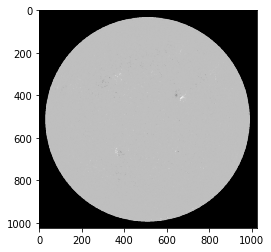

In [19]:
import matplotlib.pyplot as plt
out_nn = out_nn*1500
bicubic = out_nn[0][0].detach().numpy()
plt.imshow(bicubic, cmap='gray')

In [18]:
outfile = 'Bicubic_2k_clip.fits'
hdu = fits.PrimaryHDU(bicubic)
hdu.writeto(outfile, clobber=True)